In [1]:
import pystencils as ps
import numpy as np
import sympy as sp
from pystencils import plot as plt
import psutil
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
import matplotlib.animation as animation
from pystencils.boundaries import add_neumann_boundary, Neumann, Dirichlet, BoundaryHandling
from pystencils.slicing import slice_from_direction
import math
import time
%matplotlib inline

In [2]:
grid_points = 512
dh = ps.create_data_handling(domain_size=(grid_points, 1), periodicity=True)  # able to organize data on 256x256 lattice
μ_field = dh.add_array('mu', latex_name='μ', ghost_layers=2)  # chemical potential (functional derivative of free energy)
c_field = dh.add_array('c', ghost_layers=2)  # raw concentration that free energy depends on

In [3]:
ε, q_0, γ = sp.symbols("ε q_0 γ")

c = c_field.center
μ = μ_field.center

def f(c):
    return -ε*c**2/2 + c**4/4

bulk_free_energy_density = f(c)

covariant_free_energy_density = 1/2 * c**2

grad_sq = sum(ps.fd.diff(c, i)**2 for i in range(dh.dim))
interfacial_free_energy_density = -grad_sq

grad_fourth = sum(ps.fd.diff(ps.fd.diff(c, i), i)**2 for i in range(dh.dim)) + 2*ps.fd.diff(ps.fd.diff(c, 0), 0)*ps.fd.diff(ps.fd.diff(c, 1), 1)
interface_deformation_free_energy_density = 1/2 * grad_fourth

free_energy_density = bulk_free_energy_density + covariant_free_energy_density + interfacial_free_energy_density + interface_deformation_free_energy_density
free_energy_density

c_C**4/4 - c_C**2*ε/2 + 0.5*c_C**2 - Diff(c_C, 0, -1)**2 - Diff(c_C, 1, -1)**2 + 0.5*Diff(Diff(c_C, 0, -1), 0, -1)**2 + 1.0*Diff(Diff(c_C, 0, -1), 0, -1)*Diff(Diff(c_C, 1, -1), 1, -1) + 0.5*Diff(Diff(c_C, 1, -1), 1, -1)**2

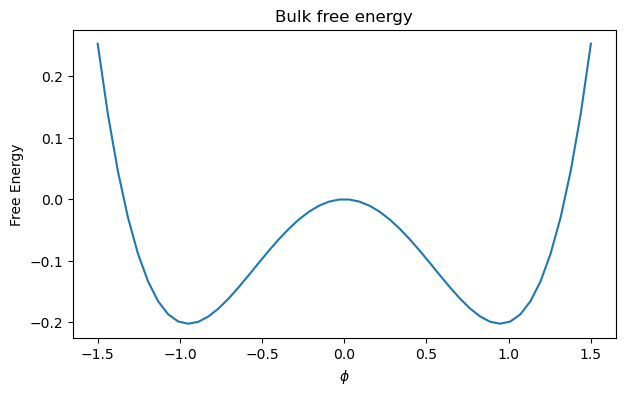

In [4]:
plt.figure(figsize=(7,4))
plt.sympy_function(bulk_free_energy_density.subs(ε, 0.9), (-1.5, 1.5))
plt.xlabel(r"$\phi$")
plt.ylabel("Free Energy")
plt.title("Bulk free energy");
plt.savefig('Symmetrized energy.jpg', dpi = 800)
plt.show()

In [5]:
# here we manually write the update equation for chemical potential μ because 
# Pystencils functional derivative method cannot handle mixed partial derivatives
def bulk_deriv(c):
    return -ε*c + c**3

μ_bulk = bulk_deriv(c)

μ_covariant = c

laplacian = sum(ps.fd.diff(c, i, i) for i in range(dh.dim))
μ_interfacial = 2*laplacian

grad_fourth = sum(ps.fd.diff(c, i, i, i, i) for i in range(dh.dim)) + 2*ps.fd.diff(c, 1, 1, 0, 0)
μ_interface_deformation = grad_fourth

μ_update_eq = μ_bulk + μ_covariant + μ_interfacial + μ_interface_deformation

μ_update_eq

c_C**3 - c_C*ε + c_C + 2*Diff(Diff(c_C, 0, -1), 0, -1) + 2*Diff(Diff(c_C, 1, -1), 1, -1) + Diff(Diff(Diff(Diff(c_C, 0, -1), 0, -1), 0, -1), 0, -1) + 2*Diff(Diff(Diff(Diff(c_C, 0, -1), 0, -1), 1, -1), 1, -1) + Diff(Diff(Diff(Diff(c_C, 1, -1), 1, -1), 1, -1), 1, -1)

In [6]:
'''
It turns out the inbuilt discretization functions neither work for above 2nd order differential equations...
Let's do this part by hand too, and hope it works.
'''
epsilon = 0.9
natural_period = 2*np.pi  # 6*np.pi/(2+np.sqrt(1+3*epsilon))
one_sixteenth_period = 1/16*natural_period
total_domain_length = (grid_points-1)*one_sixteenth_period
domain_points = np.linspace(0, total_domain_length, num = grid_points)
time_discretization = 2*10**(-5)

discretize_2ndorderPDEs = ps.fd.Discretization2ndOrder(dx=one_sixteenth_period, dt=time_discretization)

μ_interfacial_discretized = discretize_2ndorderPDEs(μ_interfacial)

μ_interfacial_discretized

-51.8764460248769*c_C + 12.9691115062192*c_E + 12.9691115062192*c_N + 12.9691115062192*c_S + 12.9691115062192*c_W

In [7]:
#we must recursively leverage the in-built function for discretizing 2nd order PDEs in order to discretize our 4th order one
second_grad_0 = ps.fd.diff(c,0,0)
second_grad_1 = ps.fd.diff(c,1,1)

second_grad_0_discretized = discretize_2ndorderPDEs(second_grad_0)
second_grad_1_discretized = discretize_2ndorderPDEs(second_grad_1)

fourth_grad_0 = ps.fd.diff(second_grad_0_discretized,0,0)
fourth_grad_0 = ps.fd.expand_diff_linear(fourth_grad_0)
fourth_grad_1 = ps.fd.diff(second_grad_1_discretized,1,1)
fourth_grad_1 = ps.fd.expand_diff_linear(fourth_grad_1)

fourth_grad_0_discretized = discretize_2ndorderPDEs(fourth_grad_0)
fourth_grad_1_discretized = discretize_2ndorderPDEs(fourth_grad_1)


fourth_grad_mixed = ps.fd.diff(second_grad_0_discretized,1,1)
fourth_grad_mixed = ps.fd.expand_diff_linear(fourth_grad_mixed)


fourth_grad_mixed_discretized = 2*discretize_2ndorderPDEs(fourth_grad_mixed)


μ_interface_deformation_discretized = fourth_grad_0_discretized + fourth_grad_1_discretized + fourth_grad_mixed_discretized
μ_interface_deformation_discretized

42.049463315187*c_2E + 42.049463315187*c_2N + 42.049463315187*c_2S + 42.049463315187*c_2W + 840.989266303741*c_C - 336.395706521496*c_E - 336.395706521496*c_N + 84.0989266303741*c_NE + 84.0989266303741*c_NW - 336.395706521496*c_S + 84.0989266303741*c_SE + 84.0989266303741*c_SW - 336.395706521496*c_W

In [8]:
μ_update_eq_discretized = μ_bulk + μ_covariant + μ_interfacial_discretized + μ_interface_deformation_discretized
μ_update_eq_discretized

42.049463315187*c_2E + 42.049463315187*c_2N + 42.049463315187*c_2S + 42.049463315187*c_2W + c_C**3 - c_C*ε + 790.112820278864*c_C - 323.426595015277*c_E - 323.426595015277*c_N + 84.0989266303741*c_NE + 84.0989266303741*c_NW - 323.426595015277*c_S + 84.0989266303741*c_SE + 84.0989266303741*c_SW - 323.426595015277*c_W

In [9]:

μ_kernel = ps.create_kernel([ps.Assignment(μ_field.center,
                                           μ_update_eq_discretized.subs(ε, epsilon))]
                           ).compile()
# here we define the update function of the chemical potential BEFORE that of yhe concentration

In [10]:
M = sp.Symbol("M")
# after suffering through the defining the dynamics of the chemical potential, 
# we know full dynamics is just the diffusionary Fick's Law of that
conserved_swift_hohenberg = ps.fd.transient(c) - ps.fd.diffusion(μ, M)  # continuity equation! M is mobility (diffusion) coefficient
conserved_swift_hohenberg

-Diffusion(mu_C, M) + Transient(c_C)

In [11]:
# 2nd order discretization of the second derivative, the middle term compounds
c_update = discretize_2ndorderPDEs(conserved_swift_hohenberg) 
c_update  # this is the symbolic rule of how c updates

c_C - 0.000518764460248769*mu_C*M + 0.000129691115062192*mu_E*M + 0.000129691115062192*mu_N*M + 0.000129691115062192*mu_S*M + 0.000129691115062192*mu_W*M

In [12]:
c_kernel = ps.create_kernel([ps.Assignment(c_field.center,
                                           c_update.subs(M, 1))]
                           ).compile()

In [13]:
dh.ghost_layers_of_field('c')

2

In [14]:
# no boundary functions because periodicity was already set in the data handler
def init(value=0.0, noise=0.02):
    for b in dh.iterate(ghost_layers=2):  # iterate() contains each domain! so an entire lattice block is each term of iterate
        b['c'].fill(value)
        np.add(b['c'], noise*(np.random.rand(*b['c'].shape)-1/2), out=b['c'])

In [15]:
def init_mixed_preperiod(phi_uni=-0.675, phi_per=-0.243, avg_phi=-0.5, noise=0.005, amp = 1/10):
    # the values here are set default for epsilon = 0.9, as extracted from the literature phase diagram
    for b in dh.iterate(ghost_layers=2):  # iterate() contains each domain! so an entire lattice block is each term of iterate
        
        # initialize the matrix that will be inserted into the concentration field later
        b['c'].fill(0)
        mixed = np.zeros(b['c'].shape)
        domain_length = mixed.shape[0]
        mixed_line = np.full(domain_length, phi_uni)
        
        # let's calculate the fraction of periodic phi INCLUDING the ghost layers from the avg phi that we desire in
        # the real system (excluding PBC ghost layers)
        system_frac_per = (avg_phi-phi_uni)/(phi_per-phi_uni)
        total_domain_frac_per = (domain_length-4)/domain_length*system_frac_per
        
        # initialize the part of the domain we consider to be inhabited by cellular
        cell_length = int((domain_length)*total_domain_frac_per)
        print('Cell length:', cell_length)
        cell_line = np.linspace(-(cell_length/2)*one_sixteenth_period,cell_length/2*one_sixteenth_period,cell_length)
        
        # define a sinusoid to initialize the periodic portion of the domain with some wave pattern
        # this quickens the simulation time to reach steady state
        sinusoid = amp*np.cos(2*np.pi/natural_period*cell_line)
        cell_line = sinusoid + phi_per - np.mean(sinusoid)  # maintain the average value
        
        # set the sinusoid in the center of the system to be the focus of the screen
        for i in range(cell_length):
            mixed_line[i+int((domain_length - cell_length)/2) + 1] = cell_line[i]
        for i in range(mixed.shape[1]):
            mixed[:,i] = mixed_line
        # finally, add noise on top of the system and place the result in the concentration field
        mixed = np.add(mixed, noise*(np.random.rand(*b['c'].shape)-1/2), out=mixed)
        np.add(b['c'], mixed, out=b['c'])
        
        print('Initialized avg phi:', np.mean(mixed[2:-2,2]))
        
        return np.mean(mixed[2:-2,2])

In [16]:
def init_from_memory(filename):
    for b in dh.iterate(ghost_layers=2):  # iterate() contains each domain! so an entire lattice block is each term of iterate
        b['c'].fill(0)
        init_memory = np.loadtxt(filename)
        np.add(b['c'], init_memory, out=b['c'])

In [17]:
def timeloop(steps=100):
    c_sync = dh.synchronization_function(['c'])
    μ_sync = dh.synchronization_function(['mu'])
    for t in range(steps):
        c_sync()
        dh.run_kernel(μ_kernel)  # need chemical potential to update first
        μ_sync()
        dh.run_kernel(c_kernel)  # followed by concentration dynamics from the chemical potential
    return dh.gather_array('c')

In [18]:
from matplotlib import animation

def animate(i):
    line.set_data(domain_points, full_evolution[i])
    if np.mean(full_evolution[i]) > 0:
        line.set_color('red')
    elif np.mean(full_evolution[i]) > -0.243:
        line.set_color('green')
        
def full_run(initialize=True, amp=1/10):
    start_time = time.perf_counter()
    
    if initialize:
        init_mixed_preperiod(avg_phi=average_phi,amp=amp)
        
    for i in range(total_frames):
        current_step = dh.cpu_arrays['c'][2:-2,2]
        full_evolution[i,:] = current_step.copy()
        timeloop(steps=int(total_steps/total_frames))
    
    end_time = time.perf_counter()        
    sim_time = end_time - start_time
    print("Sim time: ", sim_time)
    
    plt.plot(domain_points, full_evolution[0])
    plt.plot(domain_points, full_evolution[-1])
    plt.ylabel(r'$\phi$')

Sim time:  113.27754759998061


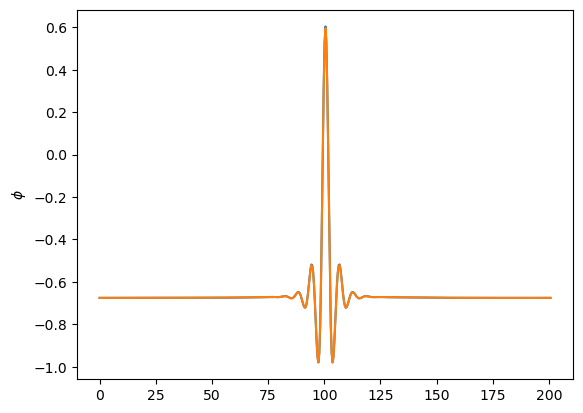

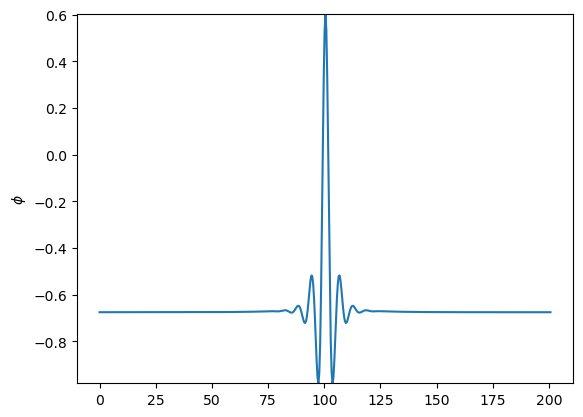

In [30]:
# in this cell we do a full run and subsequently save the animation

average_phi=-0.66
total_steps=5000000
total_frames=1000
full_evolution = np.zeros((total_frames, grid_points))
init_bool = False
amp = 1/10

full_run(initialize=init_bool,amp=amp)

fig,ax = plt.subplots()
line, = ax.plot(domain_points,full_evolution[0])
ax.set_ylim(np.min(full_evolution),np.max(full_evolution))
plt.ylabel(r'$\phi$')
    
anim = animation.FuncAnimation(fig, animate, interval=0.05, frames=total_frames-1)

anim.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\1D' + f' eps={epsilon} phi0={average_phi} amp={np.round(amp,3)}' + '.mp4', writer=animation.FFMpegWriter(fps=60))

Cell length: 29
Initialized avg phi: -0.650532470345861


-0.6505324703458637

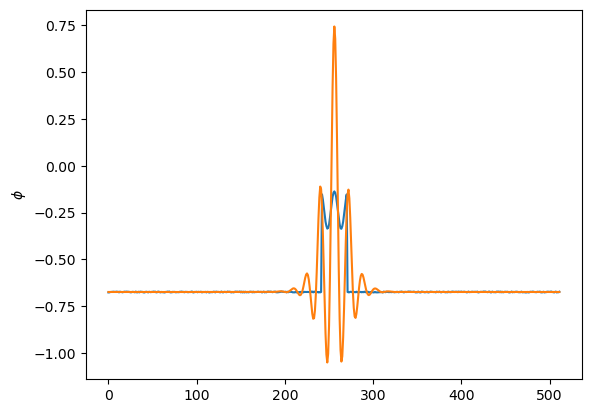

In [25]:
#here we can play with a run quickly to see if the dynamics look alright without preparing it for animation

#init()
avg_phi = -0.65
init_mixed_preperiod(avg_phi = avg_phi, amp=1/10)
c_arr = dh.cpu_arrays['c'][2:-2,2]
plt.plot(c_arr)
timeloop(steps=1000000)
plt.plot(c_arr)
plt.ylabel(r'$\phi$')
np.mean(c_arr)

### Here we extraxt digitized data from the literature to show that we have reproduced other researchers' results!

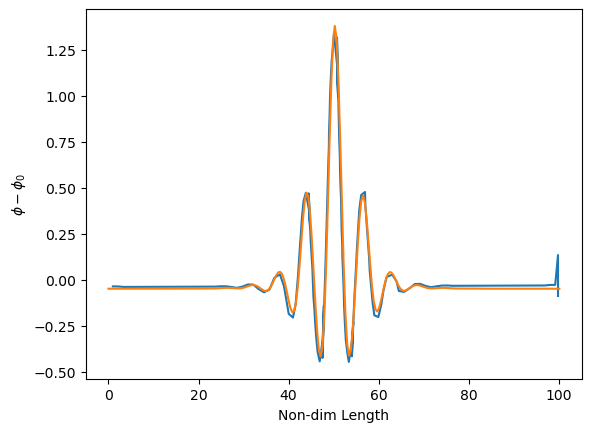

In [91]:
filename = '-0.625 odd 1 tall peak'
lit_data = np.loadtxt(r'Paper ' + filename + ' Dataset.txt')
lit_data[:,0] = lit_data[:,0]*total_domain_length
plt.plot(lit_data[:,0], lit_data[:,1])
plt.plot(domain_points, c_arr-avg_phi)
plt.xlabel('Non-dim Length')
plt.ylabel(r'$\phi - \phi_0$')
plt.savefig(r'Literature Comparisons\Compare ' + filename + '.jpg', dpi = 1200)

In [ ]:
hist, bin_edges = np.histogram(c_arrs[total_frames-1,:], bins=20)


In [ ]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=c_arr[2:-2,2], bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel(r'$\phi$')
plt.ylabel('Frequency')
#plt.title('Phi Values in Mixed State')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

# Let's add growth!!

### By adding growth in the same notebook, we can immediately start growing from a relaxed steady state. Most importantly from a relaxed state of a single (layer of) cell.

In [33]:
#here we define the growth term and a new growth dynamical equation

g, M, W, C, S = sp.symbols("g M W C S")

def growth_term(c):
    return g*(sp.tanh(S*(c + W/2 - C))*sp.tanh(S*(W/2 + C - c)) + 1)

c_growth = growth_term(c)
# after suffering through defining the dynamics of the chemical potential, 
# we know full dynamics is just the diffusionary Fick's Law of that + our proposed growth term
swift_hohenberg_growth = ps.fd.transient(c) - ps.fd.diffusion(μ, M) - c_growth  # continuity equation! M is mobility (diffusion) coefficient
swift_hohenberg_growth



-g*(tanh(S*(-c_C + C + W/2))*tanh(S*(c_C - C + W/2)) + 1) - Diffusion(mu_C, M) + Transient(c_C)

In [34]:
# 2nd order discretization of the second derivative, the middle term compounds
c_update_growth= discretize_2ndorderPDEs(swift_hohenberg_growth) 
c_update_growth  # this is the symbolic rule of how c updates

c_C - 0.000518764460248769*mu_C*M + 0.000129691115062192*mu_E*M + 0.000129691115062192*mu_N*M + 0.000129691115062192*mu_S*M + 0.000129691115062192*mu_W*M + 2.0e-5*g*tanh(S*(-2*c_C + 2*C + W)/2)*tanh(S*(2*c_C - 2*C + W)/2) + 2.0e-5*g

In [35]:
mobility=1
growth_factor=0.001
sigmoid=20
width=np.sqrt(epsilon)*9/10
center=np.sqrt(epsilon)/2

c_growth_kernel = ps.create_kernel([ps.Assignment(c_field.center,
                                           c_update_growth.subs(M, mobility).subs(g,growth_factor).subs(S,sigmoid).subs(W,width).subs(C,center))]
                           ).compile()


In [36]:
def timeloop_growth(steps=100):
    c_sync = dh.synchronization_function(['c'])
    μ_sync = dh.synchronization_function(['mu'])
    for t in range(steps):
        c_sync()
        dh.run_kernel(μ_kernel)  # need chemical potential to update first
        μ_sync()
        dh.run_kernel(c_growth_kernel)  # followed by concentration dynamics from the chemical potential, which now grow too
    return dh.gather_array('c')

In [37]:
from scipy.signal import find_peaks

def cell_growth(start_from_single_cell = True):
    start_time = time.perf_counter()
    
    if start_from_single_cell:
        init_from_memory(single_cell_filename)
    new_cell_step = []
    for i in range(total_frames):
        current_step = dh.cpu_arrays['c'][2:-2,2]
        full_evolution[i,:] = current_step.copy()
        timeloop_growth(steps=int(total_steps_growth/total_frames))
        peaks = find_peaks(full_evolution[i,:], center-width/2)[0]
        
        if np.size(peaks) > 1 and len(new_cell_step) == 0:
            new_cell_step.append(i/total_frames*total_steps_growth)
        
    
    end_time = time.perf_counter()        
    sim_time = end_time - start_time
    print("Growth Sim time: ", sim_time)
    
    plt.plot(domain_points, full_evolution[-1])
    plt.ylabel(r'$\phi$')
    plt.show()
    
    return np.array(new_cell_step)[0]

## Let's check qualitative behavior for a range of growth factors

In [40]:
#do we want to actually reset the new_cell_times list? only do it if you think you have bad data
new_cell_times = []
all_g_values = []

Growth Sim time:  329.65676849999


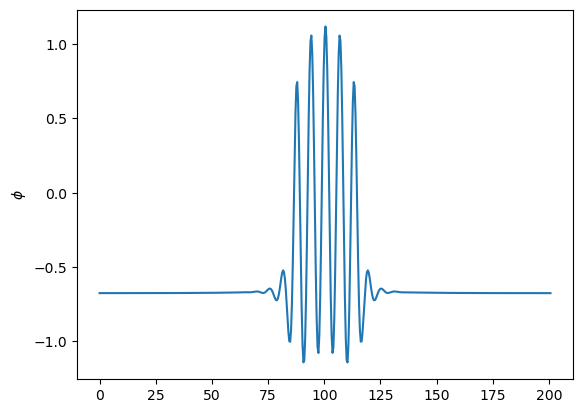

New Cell Time:  74.24000000000001


In [ ]:
g_values = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8, 1] #np.linspace(0.02,0.08,num=4) #10.0**np.arange(-3,1,1)
total_steps_growth = 8000000
total_frames =  1000
full_evolution = np.zeros((total_frames, grid_points))
single_cell_bool = True
single_cell_filename = r'Initialization States\steady single cell 512.txt'


for g_val in g_values:
    all_g_values.append(g_val)
    c_growth_kernel = ps.create_kernel([ps.Assignment(c_field.center,
                                           c_update_growth.subs(M, mobility).subs(g,g_val).subs(S,sigmoid).subs(W,width).subs(C,center))]
                           ).compile()

    new_cell_times.append(cell_growth(start_from_single_cell=single_cell_bool)*time_discretization)
    print('New Cell Time: ', new_cell_times[-1])
    plt.show()
    fig,ax = plt.subplots()
    line, = ax.plot(domain_points,full_evolution[0])
    ax.set_ylim(np.min(full_evolution),np.max(full_evolution))
    plt.hlines(center-width/2,np.min(domain_points), np.max(domain_points))
    plt.ylabel(r'$\phi$')
    plt.xlabel('Non-dimensionalized Length')
    
    
    anim = animation.FuncAnimation(fig, animate, interval=0.05, frames=total_frames-1)

    anim.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\Growth\1D' + f' {grid_points} eps={epsilon} g={g_val} initphi={np.round(np.mean(full_evolution[0]),3)}' + '.mp4', writer=animation.FFMpegWriter(fps=60))



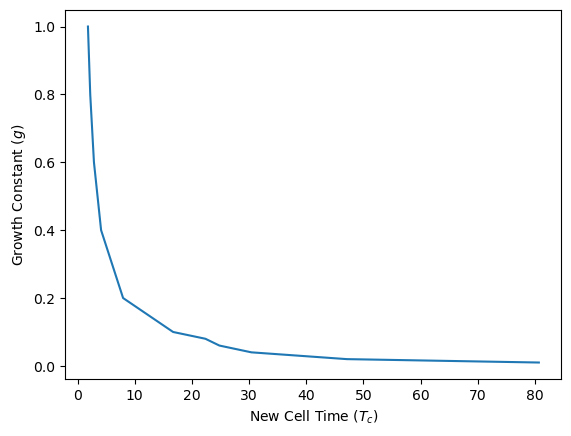

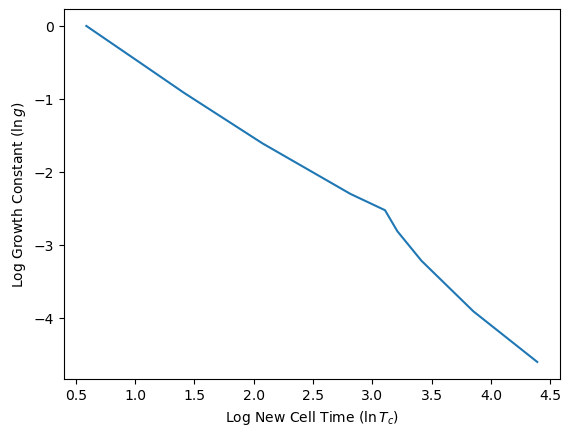

In [43]:
plt.plot(new_cell_times, all_g_values)
plt.ylabel(r'Growth Constant ($g$)')
plt.xlabel(r'New Cell Time ($T_c$)')
plt.savefig('growth vs. new cells.jpg', dpi=1200)
plt.show()
plt.plot(np.log(new_cell_times), np.log(all_g_values))
plt.ylabel(r'Log Growth Constant ($\ln g$)')
plt.xlabel(r'Log New Cell Time ($\ln T_c$)')
plt.savefig('log-log growth vs. new cells.jpg', dpi=1200)

In [108]:

myorder = [1, 2, 3, 0, 4, 5, 6]
new_cell_times = [new_cell_times[i] for i in myorder]
all_g_values = [all_g_values[i] for i in myorder]
new_cell_times, all_g_values

([81.30000000000001,
  58.50000000000001,
  47.7,
  27,
  16.900000000000002,
  5.500000000000001,
  2.24],
 [0.01, 0.015, 0.02, 0.05, 0.1, 0.3, 0.8])

In [41]:
new_cell_times, all_g_values

([80.70000000000002,
  47.1,
  30.400000000000002,
  24.8,
  22.35,
  16.700000000000003,
  7.950000000000001,
  4.1000000000000005,
  2.85,
  2.2,
  1.8],
 [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8, 1])

Cell length: 14
Initialized avg phi: -0.651376836992539
Sim time:  61.21594870000263
Sim time:  214.69827730000543


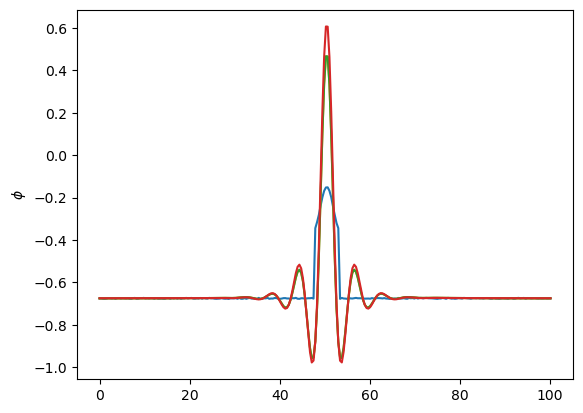

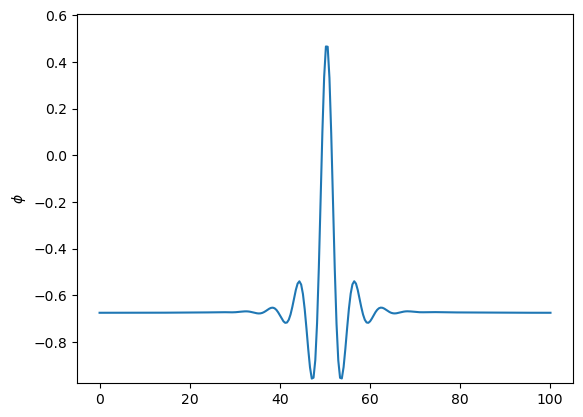

In [30]:
average_phi = -0.65
total_steps = 3000000
total_steps_growth = 5000000
total_frames =  1000
full_evolution = np.zeros((total_frames, grid_points))
single_cell_bool = True

cell_growth(start_from_single_cell=single_cell_bool)

fig,ax = plt.subplots()
line, = ax.plot(domain_points,full_evolution[0])
ax.set_ylim(np.min(full_evolution),np.max(full_evolution))
plt.ylabel(r'$\phi$')
    
anim = animation.FuncAnimation(fig, animate, interval=0.05, frames=total_frames-1)

anim.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\Growth\1D' + f' eps={epsilon} g={growth_factor} initphi={np.round(np.mean(full_evolution[0]),3)}' + '.mp4', writer=animation.FFMpegWriter(fps=60))


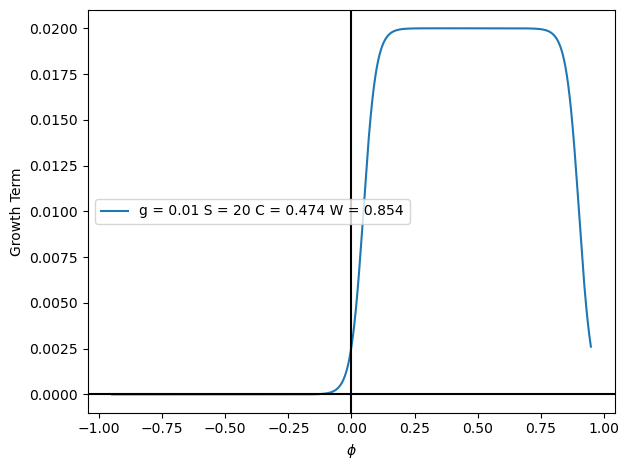

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import cmath as cm
%matplotlib inline

growth = lambda g,S,C,W,x: g*(np.tanh(S*(x-C+W/2))*np.tanh(S*(-x+C+W/2)) + 1)
growth_factor = 0.01
#Here we plot the form of the growth term

x_values_large = np.linspace(-np.sqrt(epsilon),np.sqrt(epsilon), 10000)

y_growth = growth(growth_factor,sigmoid,center,width, x_values_large)
plt.plot(x_values_large, y_growth, label = f'g = {growth_factor} S = {sigmoid} C = {np.round(center,3)} W = {np.round(width,3)}')
plt.xlabel(r'$\phi$')
plt.ylabel(r'Growth Term')
plt.legend()
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.tight_layout()
plt.savefig(f'g={growth_factor}.jpg', dpi = 1200)
plt.show()

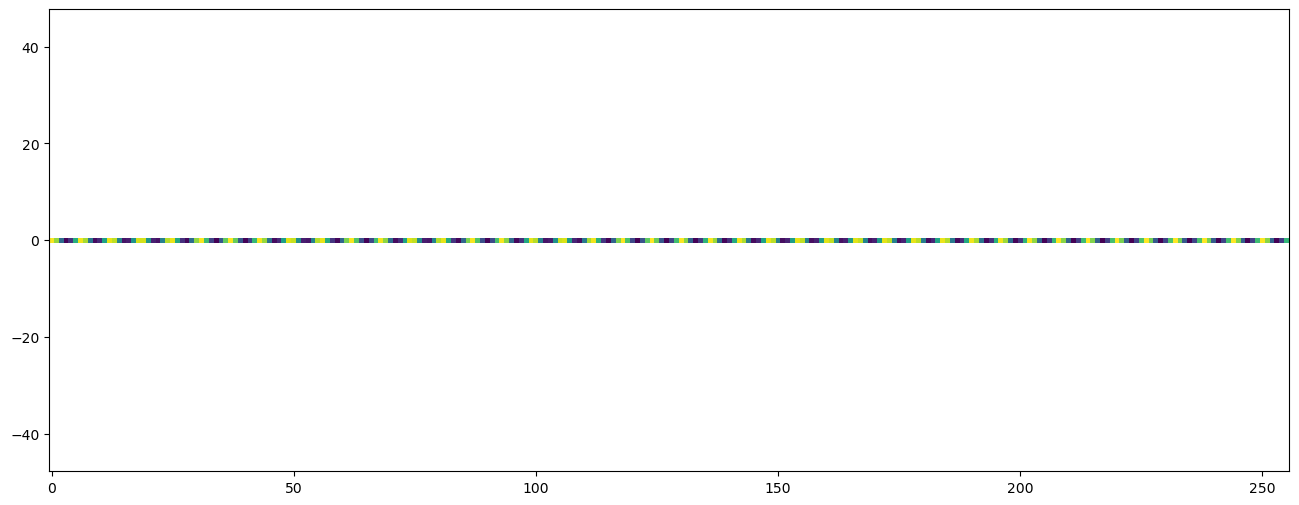

In [23]:
init(0,0.01) # initialize the system at time = 0
# run the simulation and save a video in time
ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=2500)
writervideo = animation.FFMpegWriter(fps=60)
ani.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\1Dswift-hohenberg.mp4', writer=writervideo)